In [ ]:
!pip install catboost

In [15]:
!unzip /content/archive.zip -d /content

Archive:  /content/archive.zip
  inflating: /content/Lung_Cancer_Dataset.csv  


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump

In [58]:
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve,roc_auc_score,precision_recall_curve,make_scorer, fbeta_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

In [18]:
df = pd.read_csv('/content/Lung_Cancer_Dataset.csv')

## **Note**
**GENDER**: Indicates the gender of the individual (M for Male, F for Female).

**AGE**: Represents the age of the individual, contributing to the analysis of age-related patterns.

**SMOKING**: Reflects the smoking habits of individuals, categorized to capture various levels of smoking intensity.

**YELLOW_FINGERS**: Describes the presence of yellow fingers, potentially associated with lifestyle choices or health conditions.

**ANXIETY**: Measures the anxiety level of individuals, offering insights into the psychological aspects of health.

**PEER_PRESSURE**: Indicates the influence of peer pressure on lifestyle choices.

**CHRONIC DISEASE**: Highlights the presence or absence of chronic diseases, a crucial health factor.

**FATIGUE**: Reflects the level of fatigue experienced by individuals, providing information on overall health.

**ALLERGY**: Indicates the presence or absence of allergies, potentially relevant to respiratory health.

**WHEEZING**: Describes whether wheezing is present, a symptom often associated with respiratory issues.

**ALCOHOL CONSUMING**: Indicates the alcohol consumption habits of individuals, which can impact overall health.

**COUGHING**: Represents the occurrence and severity of coughing, a respiratory symptom.

**SHORTNESS OF BREATH**: Indicates the presence or absence of shortness of breath, another respiratory indicator.

**SWALLOWING DIFFICULTY**: Describes difficulties in swallowing, potentially linked to respiratory or other health concerns.

**CHEST PAIN**: Indicates the presence or absence of chest pain, a symptom associated with various health conditions.

**LUNG_CANCER**: The target variable, specifying whether the individual has been diagnosed with lung cancer (YES or NO).

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_CANCER            

In [20]:
df.head(5)

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [22]:
na_rows = df[df.isna().any(axis=1)]
na_rows.shape[0]

0

In [80]:
def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object':
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

data=labelencoder(df)

In [81]:
data.head(10)

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1
2,0,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0
3,1,63,2,2,2,1,1,1,1,1,2,1,1,2,2,0
4,0,63,1,2,1,1,1,1,1,2,1,2,2,1,1,0
5,0,75,1,2,1,1,2,2,2,2,1,2,2,1,1,1
6,1,52,2,1,1,1,1,2,1,2,2,2,2,1,2,1
7,0,51,2,2,2,2,1,2,2,1,1,1,2,2,1,1
8,0,68,2,1,2,1,1,2,1,1,1,1,1,1,1,0
9,1,53,2,2,2,2,2,1,2,1,2,1,1,2,2,1


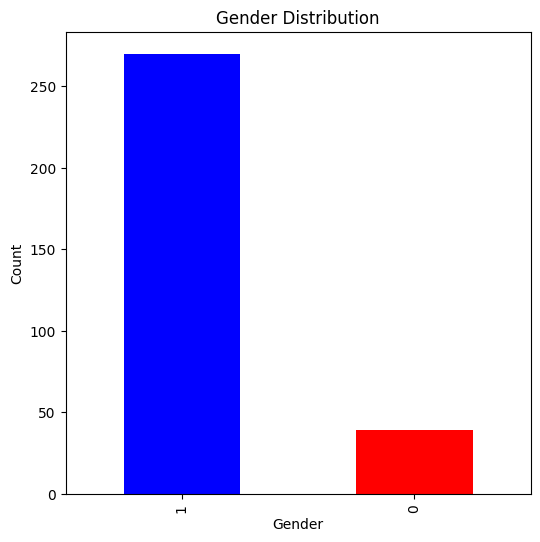

In [39]:
counts = df['LUNG_CANCER'].value_counts()
plt.figure(figsize=(6,6))
counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [67]:
trainX=df.drop('LUNG_CANCER',axis=1)
trainY=df['LUNG_CANCER']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

In [62]:
classifiers = {
    'Logistic Regression': (LogisticRegression(), {'classifier__C': [0.01 ,0.1, 1, 10],'classifier__max_iter': [1000]}),
    'Support Vector Classifier': (SVC(probability=True), {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']}),
    'Naive Bayes': (GaussianNB(), {}),
    'Decision Tree': (DecisionTreeClassifier(), {'classifier__max_depth': [None, 10, 20, 40]}),
    'Random Forest': (RandomForestClassifier(), {'classifier__n_estimators': [50, 100, 200, 500]}),
    'AdaBoost': (AdaBoostClassifier(), {'classifier__n_estimators': [50, 100, 200,500]}),
    'Gradient Boosting': (GradientBoostingClassifier(), {'classifier__n_estimators': [50, 100, 200, 500]}),
    'XGBoost': (XGBClassifier(), {'classifier__n_estimators': [50, 100, 200]}),
    'Catboost': (CatBoostClassifier(silent=True), {'classifier__iterations': [50, 100, 200]}),
    'K Nearest Neighbors': (KNeighborsClassifier(), {'classifier__n_neighbors': [3, 5, 7, 9]}),
    'Gaussian Process': (GaussianProcessClassifier(), {}),
}
scalers={'Standard Scaler' :StandardScaler(),
         'Min Max Scaler':MinMaxScaler(),
         'Roobust Scaler': RobustScaler(),
         'No Scaler': None
        }

stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f2_scorer = make_scorer(fbeta_score, beta=2)
f05_scorer = make_scorer(fbeta_score, beta=0.5)

In [63]:
best_roc = 0
best_classifier = None
best_scaler = None
best_params=None
for classifier_name, (classifier, param_grid) in classifiers.items():
    for scaler_name, scaler in scalers.items():
        pipeline = Pipeline([
            ('scaler', scaler),
            ('classifier', classifier)
        ])
        grid_search = GridSearchCV(pipeline, param_grid, cv=stratified_kfold, scoring="roc_auc", n_jobs=-1)
        grid_search.fit(X_train, y_train)
        mean_roc = grid_search.best_score_
        if mean_roc > best_roc:
            best_roc = mean_roc
            best_classifier = classifier_name
            best_scaler = scaler_name
            best_prams = grid_search.best_params_
print("Best model:", best_classifier)
print("Best params:", best_prams)
print("Best scaler:", best_scaler)
print("Best mean f2 score:", best_roc)

Best model: Support Vector Classifier
Best params: {'classifier__C': 1, 'classifier__kernel': 'linear'}
Best scaler: No Scaler
Best mean f2 score: 0.9506595126313436


In [64]:
best_model = classifiers[best_classifier][0]
best_scaler_ = scalers[best_scaler]
best_params_ = best_prams
best_params_cleaned = {}
for key, value in best_params_.items():
    new_key = key.split('__')[-1]
    best_params_cleaned[new_key] = value

best_pipeline = Pipeline([
    ('scaler', best_scaler_),
    ('classifier', best_model.set_params(**best_params_cleaned))
])
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', None),
                ('classifier', SVC(C=1, kernel='linear', probability=True))])

In [68]:
y_train_proba = best_pipeline.predict_proba(X_train)[:, 1]
best_f05_score = 0
best_threshold = 0
for i in range(10000):
    y_pred_thresholded = (y_train_proba >= i/10000).astype(int)
    f05= fbeta_score(y_train, y_pred_thresholded, beta=0.5)

    if f05 > best_f05_score:
        best_f05_score = f05
        best_threshold = i/10000
print("Best threshold for f05 score:", best_threshold)

Best threshold for f05 score: 0.814


In [66]:
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

y_pred_thresholded = (y_pred_proba >= best_threshold).astype(int)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
fpr, tpr, thresholds2 = roc_curve(y_test, y_pred_proba)
test_roc_score = roc_auc_score(y_test, y_pred_proba)
test_acc_score = accuracy_score(y_test, y_pred_thresholded)
test_cm = confusion_matrix(y_test, y_pred_thresholded)
test_cr = classification_report(y_test, y_pred_thresholded)
print("Test accuracy is:", test_acc_score)
print("Confusion Matrix:\n", test_cm)
print("Classification Report:\n", test_cr)

Test accuracy is: 0.9032258064516129
Confusion Matrix:
 [[ 3  0]
 [ 6 53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50         3
           1       1.00      0.90      0.95        59

    accuracy                           0.90        62
   macro avg       0.67      0.95      0.72        62
weighted avg       0.97      0.90      0.92        62



In [71]:
dump(best_pipeline, 'LungCancerPredictionModel.joblib')

['LungCancerPredictionModel.joblib']

In [ ]:
# loaded_pipeline = load('pipeline_model.joblib')

In [79]:
single_test = np.array([[1, 45, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1]])

In [78]:
y_pred = best_pipeline.predict(single_test)
y_pred

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([0])